# import

In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import kstest, gaussian_kde, ks_2samp
from scipy.spatial.distance import jensenshannon
# from table_evaluator import load_data, TableEvaluator
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

In [2]:
set_verbosity(ERROR)

# load data

In [3]:
# folder_path = 'gtfs'

# agency = pd.read_csv(f'{folder_path}/agency.txt')
# calendar = pd.read_csv(f'{folder_path}/calendar.txt')
# calendar_dates = pd.read_csv(f'{folder_path}/calendar_dates.txt')
# fare_attributes = pd.read_csv(f'{folder_path}/fare_attributes.txt')
# fare_rules = pd.read_csv(f'{folder_path}/fare_rules.txt')
# feed_info = pd.read_csv(f'{folder_path}/feed_info.txt')
# frequencies = pd.read_csv(f'{folder_path}/frequencies.txt')
# routes = pd.read_csv(f'{folder_path}/routes.txt')
# shapes = pd.read_csv(f'{folder_path}/shapes.txt')
# stops = pd.read_csv(f'{folder_path}/stops.txt')
# stop_times = pd.read_csv(f'{folder_path}/stop_times.txt')
# transfers = pd.read_csv(f'{folder_path}/transfers.txt')
# trips = pd.read_csv(f'{folder_path}/trips.txt')

In [4]:
# join map
# # Read GTFS CSV files
# agency = pd.read_csv('gtfs/agency.txt')
# stops = pd.read_csv('gtfs/stops.txt')
# routes = pd.read_csv('gtfs/routes.txt')
# trips = pd.read_csv('gtfs/trips.txt')
# stop_times = pd.read_csv('gtfs/stop_times.txt')
# calendar = pd.read_csv('gtfs/calendar.txt')
# routes_agency = routes.merge(agency, on='agency_id', how='left')
# trips_routes = trips.merge(routes_agency, on='route_id', how='left')
# stop_times_trips = stop_times.merge(trips_routes, on='trip_id', how='left')
# stop_times_trips_stops = stop_times_trips.merge(stops, on='stop_id', how='left')
# trips_calendar = trips.merge(calendar, on='service_id', how='left')
# joined_data = stop_times_trips_stops.merge(trips_calendar, on=['trip_id', 'route_id', 'service_id'], how='left', suffixes=('', '_y'))
# joined_data = joined_data.loc[:, ~joined_data.columns.str.endswith('_y')]
# joined_data.head()

In [5]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [6]:
# def preprocess(data_collection):
    # for k, v in data_collection.items():
    #     current_data = v.select_dtypes(include=[np.number]).astype(np.float32)
    #     scaler = StandardScaler()
    #     data_collection[k] = scaler.fit_transform(current_data)
    # return data_collection

In [7]:
real_data_collection = load_data_collection("gtfs")

# preprocess

In [8]:
def individual_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [9]:
def format_individual_data(data, preprocess_dict, factorization_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            data[col] = data[col].map(factorization_dict[col])
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '').astype(int)
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col], format='%Y%m%d') - timestamp
                            data[col] = cur_col.dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_data = scaler.fit_transform(data)
    return data

In [10]:
def create_factorization_dict(data_collection, selected_columns):
    # Combine unique values from all DataFrames for each selected column
    unique_values = {}
    for col in selected_columns:
        local_unique_values = pd.concat([df[col] for df in data_collection.values() if col in df.columns]).unique()
        unique_values[col] = local_unique_values

    # Create a nested factorization dictionary
    factorization_dict = {}
    for col, local_unique_values in unique_values.items():
        factorization_dict[col] = {v: i for i, v in enumerate(local_unique_values)}

    return factorization_dict

In [11]:
features_to_factorize = ['agency_id','agency_name',
                         'agency_url','agency_timezone',
                         'agency_lang','service_id',
                        'route_id','route_short_name',
                        'route_long_name','route_color',
                         'route_text_color','contract_id',
                        'shape_id','stop_id',
                        'stop_name','parent_station',
                        'platform_code','trip_id',
                        'stop_headsign','trip_headsign']
factorization_dict = create_factorization_dict(real_data_collection, features_to_factorize)

## preprocess individual data

### agency

In [12]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id', 'agency_name','agency_url','agency_timezone','agency_lang']
preprocess_dict['transformation']['to_strip'] = ['agency_phone']
real_data_collection['agency'] = format_individual_data(real_data_collection['agency'], preprocess_dict, factorization_dict)

C:\Users\ouzho\AppData\Local\Temp\ipykernel_5444\3439179761.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\D', '').astype(int)


### calendar

In [13]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = format_individual_data(real_data_collection['calendar'], preprocess_dict, factorization_dict)

### calendar_dates

In [14]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = format_individual_data(real_data_collection['calendar_dates'], preprocess_dict, factorization_dict)

### routes

In [15]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_short_name',
                                                 'route_long_name',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = format_individual_data(real_data_collection['routes'], preprocess_dict, factorization_dict)

### shapes

In [16]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['shape_id']
real_data_collection['shapes'] = format_individual_data(real_data_collection['shapes'], preprocess_dict, factorization_dict)

### stops

In [17]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','stop_name','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = format_individual_data(real_data_collection['stops'], preprocess_dict, factorization_dict)

### stop_times

In [18]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = format_individual_data(real_data_collection['stop_times'], preprocess_dict, factorization_dict)

### trips

In [19]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = format_individual_data(real_data_collection['trips'], preprocess_dict, factorization_dict)

In [20]:
del real_data_collection['shapes']

## Create Metadata

In [21]:
def auto_detect_relation(data_collection):
    metadata = {}
    for df_name, df in data_collection.items():
        parent = {}
        child = []
        primary_key = []
        foreign_key = []
        for col in df.columns:
            if 'id' in col:
                if df[col].nunique() == len(df):
                    primary_key = [col, len(df)]
                else:
                    foreign_key.append(col)
        for foreign_df_name, foreign_df in data_collection.items():
            if foreign_df_name != df_name:
                for col in foreign_df.columns:
                    if 'id' in col:
                        for fr_k in foreign_key:
                            if col == fr_k and foreign_df[col].nunique() == len(foreign_df):
                                parent[foreign_df_name] = fr_k
                        if primary_key != []:
                            if col == primary_key[0] and foreign_df[col].nunique() != len(foreign_df):
                                child.append(foreign_df_name)
        metadata[df_name] = {'primary_key':primary_key,
                             'parent':parent,
                             'child':child}
    return metadata

In [22]:
metadata = auto_detect_relation(real_data_collection)

In [23]:
metadata

{'agency': {'primary_key': ['agency_id', 15],
  'parent': {},
  'child': ['routes']},
 'calendar': {'primary_key': ['service_id', 121],
  'parent': {},
  'child': ['calendar_dates', 'trips']},
 'calendar_dates': {'primary_key': [],
  'parent': {'calendar': 'service_id'},
  'child': []},
 'routes': {'primary_key': ['route_id', 215],
  'parent': {'agency': 'agency_id'},
  'child': ['trips']},
 'stops': {'primary_key': ['stop_id', 6714],
  'parent': {},
  'child': ['stop_times']},
 'stop_times': {'primary_key': [],
  'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
  'child': []},
 'trips': {'primary_key': ['trip_id', 32403],
  'parent': {'calendar': 'service_id', 'routes': 'route_id'},
  'child': ['stop_times']}}

## Scaling

In [24]:
def scale_individual_df(df):
    scaler = StandardScaler()
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [25]:
def extract_key_and_scaled_features(df, label_columns):
    labels = df[label_columns]
    table = df.drop(columns=label_columns)
    table_column_names = table.columns
    scaled_table, table_scaler = scale_individual_df(table)
    scaled_labels, labels_scaler = scale_individual_df(labels)
    return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [26]:
def batch_preprocessing(data_collection, metadata):
    processed_data_collection = {}
    for df_name, df in data_collection.items():
        primary_key = []
        foreign_key = []
        if metadata[df_name]['primary_key'] != []:
            primary_key = [metadata[df_name]['primary_key'][0]]
        if metadata[df_name]['parent'] != {}:
            foreign_key = list(metadata[df_name]['parent'].values())
        label_columns = primary_key + foreign_key
        table, labels, table_scaler, labels_scaler, table_columns = extract_key_and_scaled_features(df, label_columns)
        processed_data_collection[df_name] = {'table':table,
                                              'labels':labels,
                                              'table_scaler':table_scaler,
                                              'labels_scaler':labels_scaler,
                                              'table_col_names':table_columns,
                                              'label_col_names':label_columns,
                                             'metadata':metadata[df_name]}
    return processed_data_collection

In [27]:
processed_data_collection = batch_preprocessing(real_data_collection, metadata)
del real_data_collection

# GAN Building

## Sample & Noise Generation

In [28]:
def generate_noise(n_samples, n_features):
    return np.random.uniform(0, 1, (n_samples, n_features))

## Additional Custom Function (Wasserstein Loss)

In [29]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

## Define Plotting Function For G/D Loss

In [30]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(discriminator_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, Discriminator

In [31]:
def build_generator(table_dim, labels_dim, latent_dim=100):
    noise_input = layers.Input(shape=(latent_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    bn_layer1 = layers.BatchNormalization()(merge_input)
    hidden_layer1 = layers.Dense(128,activation='LeakyReLU')(bn_layer1)
    hidden_layer2 = layers.Dense(128,activation='LeakyReLU')(hidden_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer2)
    output_layer = layers.Dense(table_dim, activation='sigmoid')(bn_layer2)
    generator = models.Model([noise_input, labels_input], output_layer)
    return generator

In [32]:
def build_discriminator(table_dim, labels_dim):
    table_input = layers.Input(shape=(table_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    bn_layer1 = layers.BatchNormalization()(merge_input)
    hidden_layer1 = layers.Dense(128,activation='LeakyReLU')(bn_layer1)
    hidden_layer2 = layers.Dense(128,activation='LeakyReLU')(hidden_layer1)
    bn_layer2 = layers.BatchNormalization()(hidden_layer2)
    output_layer = layers.Dense(1, activation='sigmoid')(bn_layer2)
    discriminator = models.Model([table_input, labels_input], output_layer)
    discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return discriminator

In [33]:
# def build_discriminator(table_dim, labels_dim):
#     table_input = layers.Input(shape=(table_dim,))
#     labels_input = layers.Input(shape=(labels_dim,))
#     merge_input = layers.Concatenate()([table_input, labels_input])
#     bn_layer1 = layers.BatchNormalization()(merge_input)
#     hidden_layer1 = layers.Dense(128,activation='LeakyReLU')(bn_layer1)
#     reshape_layer = layers.Reshape((4, 32))(hidden_layer1)
#     conv1 = layers.Conv1D(64,
#                           kernel_size=4,
#                           strides=2,
#                           padding="same",
#                           activation="LeakyReLU")(reshape_layer)
#     # conv2 = layers.Conv1D(64,
#     #                       kernel_size=4,
#     #                       strides=2,
#     #                       padding="same",
#     #                       activation="LeakyReLU")(conv1)
#     bn_layer2 = layers.BatchNormalization()(conv1)
#     flatten_layer = layers.Flatten()(bn_layer2)
#     output_layer = layers.Dense(1, activation='sigmoid')(flatten_layer)
#     discriminator = models.Model([table_input, labels_input], output_layer)
#     discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return discriminator

In [34]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    noise_input = layers.Input(shape=(generator.input_shape[0][1],))
    labels_input = layers.Input(shape=(generator.input_shape[1][1],))
    generator_output = generator([noise_input, labels_input])
    discriminator_output = discriminator([generator_output, labels_input])
    gan = models.Model(inputs=[noise_input, labels_input], outputs=discriminator_output)
    gan.compile(optimizer='adam', loss='binary_crossentropy')
    return gan

In [35]:
# def build_gan(generator, discriminator):
#     noise_input = layers.Input(shape=(generator.input_shape[0][1],))
#     label_input = layers.Input(shape=(generator.input_shape[1][1],))
#     noise_input, label_input = generator.input
#     generator_output = generator.output
#     discriminator.trainable = False
#     validation = discriminator([generator_output, label_input])
#     gan = model.Model([noise_input, label_input], validation)
#     gan.compile(optimizer='adam', loss='binary_crossentropy')
#     return gan

## Define Training Strategy

In [36]:
def train_individual_gan(name, real_table, real_labels, epochs=50, batch_size=128, latent_dim=100, seed=123, return_logs=True):
    class_counts = real_labels.nunique().tolist()
    generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    discriminator = build_discriminator(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, discriminator)
    
    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        discriminator_logs = []
    
    for epoch in range(epochs):
        start_time = time.time()
        idx = np.random.randint(0, real_table.shape[0], batch_size)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        
        x_real_labels = real_labels.iloc[idx]
        x_real_table = real_table.iloc[idx]
        #x_fake_labels = np.random.rand(batch_size, real_labels.shape[1])
        x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=batch_size) for class_counts in class_counts])
        x_fake_table = generator.predict([noise, x_fake_labels])
        
        d_loss_real, _ = discriminator.train_on_batch([x_real_table, x_real_labels], y_real)
        d_loss_fake, _ = discriminator.train_on_batch([x_fake_table, x_fake_labels], y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch([noise, x_fake_labels], y_real)
        
        if return_logs:
            generator_logs.append(g_loss)
            discriminator_logs.append(d_loss)
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if (epoch) % 10 == 0:
            print(f"[Epoch: {epoch}] [D loss: {np.round(d_loss, 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
    generator.save('models/'+name+'_gan.h5')
    
    if return_logs:
        return generator_logs, discriminator_logs

In [37]:
def collection_training(data_collection, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in data_collection.items():
        start_time = time.time()
        print(f'Learning \"{df_name}\" data......')
        generator_log, discriminator_log = train_individual_gan(df_name,
                                                                  content['table'],
                                                                  content['labels'],
                                                                epochs=training_parameter_dict[df_name]['epochs'],
                                                                  return_logs=True)
        in_loop_elapsed_time = time.time() - start_time
        minutes, seconds = divmod(in_loop_elapsed_time, 60)
        print("Time Used: %dm %ds" % (minutes, seconds))
        print('.')
        print('.')
        logs.append([df_name, generator_log, discriminator_log])
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [38]:
training_parameter_dict = {}
for df_name, content in processed_data_collection.items():
    nrows = content['table'].shape[0]
    training_parameter_dict[df_name] = {'epochs':500}

In [39]:
training_parameter_dict

{'agency': {'epochs': 500},
 'calendar': {'epochs': 500},
 'calendar_dates': {'epochs': 500},
 'routes': {'epochs': 500},
 'stops': {'epochs': 500},
 'stop_times': {'epochs': 500},
 'trips': {'epochs': 500}}

Learning "agency" data......
[Epoch: 0] [D loss: 0.897] [G loss: 0.906] [Speed: 0.5 it/s]
[Epoch: 10] [D loss: 0.706] [G loss: 0.675] [Speed: 15.38 it/s]
[Epoch: 20] [D loss: 0.696] [G loss: 0.642] [Speed: 15.87 it/s]
[Epoch: 30] [D loss: 0.695] [G loss: 0.63] [Speed: 16.39 it/s]
[Epoch: 40] [D loss: 0.697] [G loss: 0.634] [Speed: 16.13 it/s]
[Epoch: 50] [D loss: 0.695] [G loss: 0.628] [Speed: 15.87 it/s]
[Epoch: 60] [D loss: 0.696] [G loss: 0.61] [Speed: 16.39 it/s]
[Epoch: 70] [D loss: 0.694] [G loss: 0.618] [Speed: 14.92 it/s]
[Epoch: 80] [D loss: 0.697] [G loss: 0.625] [Speed: 13.15 it/s]
[Epoch: 90] [D loss: 0.694] [G loss: 0.595] [Speed: 13.51 it/s]
[Epoch: 100] [D loss: 0.694] [G loss: 0.591] [Speed: 12.98 it/s]
[Epoch: 110] [D loss: 0.694] [G loss: 0.566] [Speed: 13.33 it/s]
[Epoch: 120] [D loss: 0.694] [G loss: 0.535] [Speed: 13.7 it/s]
[Epoch: 130] [D loss: 0.694] [G loss: 0.498] [Speed: 13.51 it/s]
[Epoch: 140] [D loss: 0.694] [G loss: 0.441] [Speed: 13.15 it/s]
[Epoch: 150]

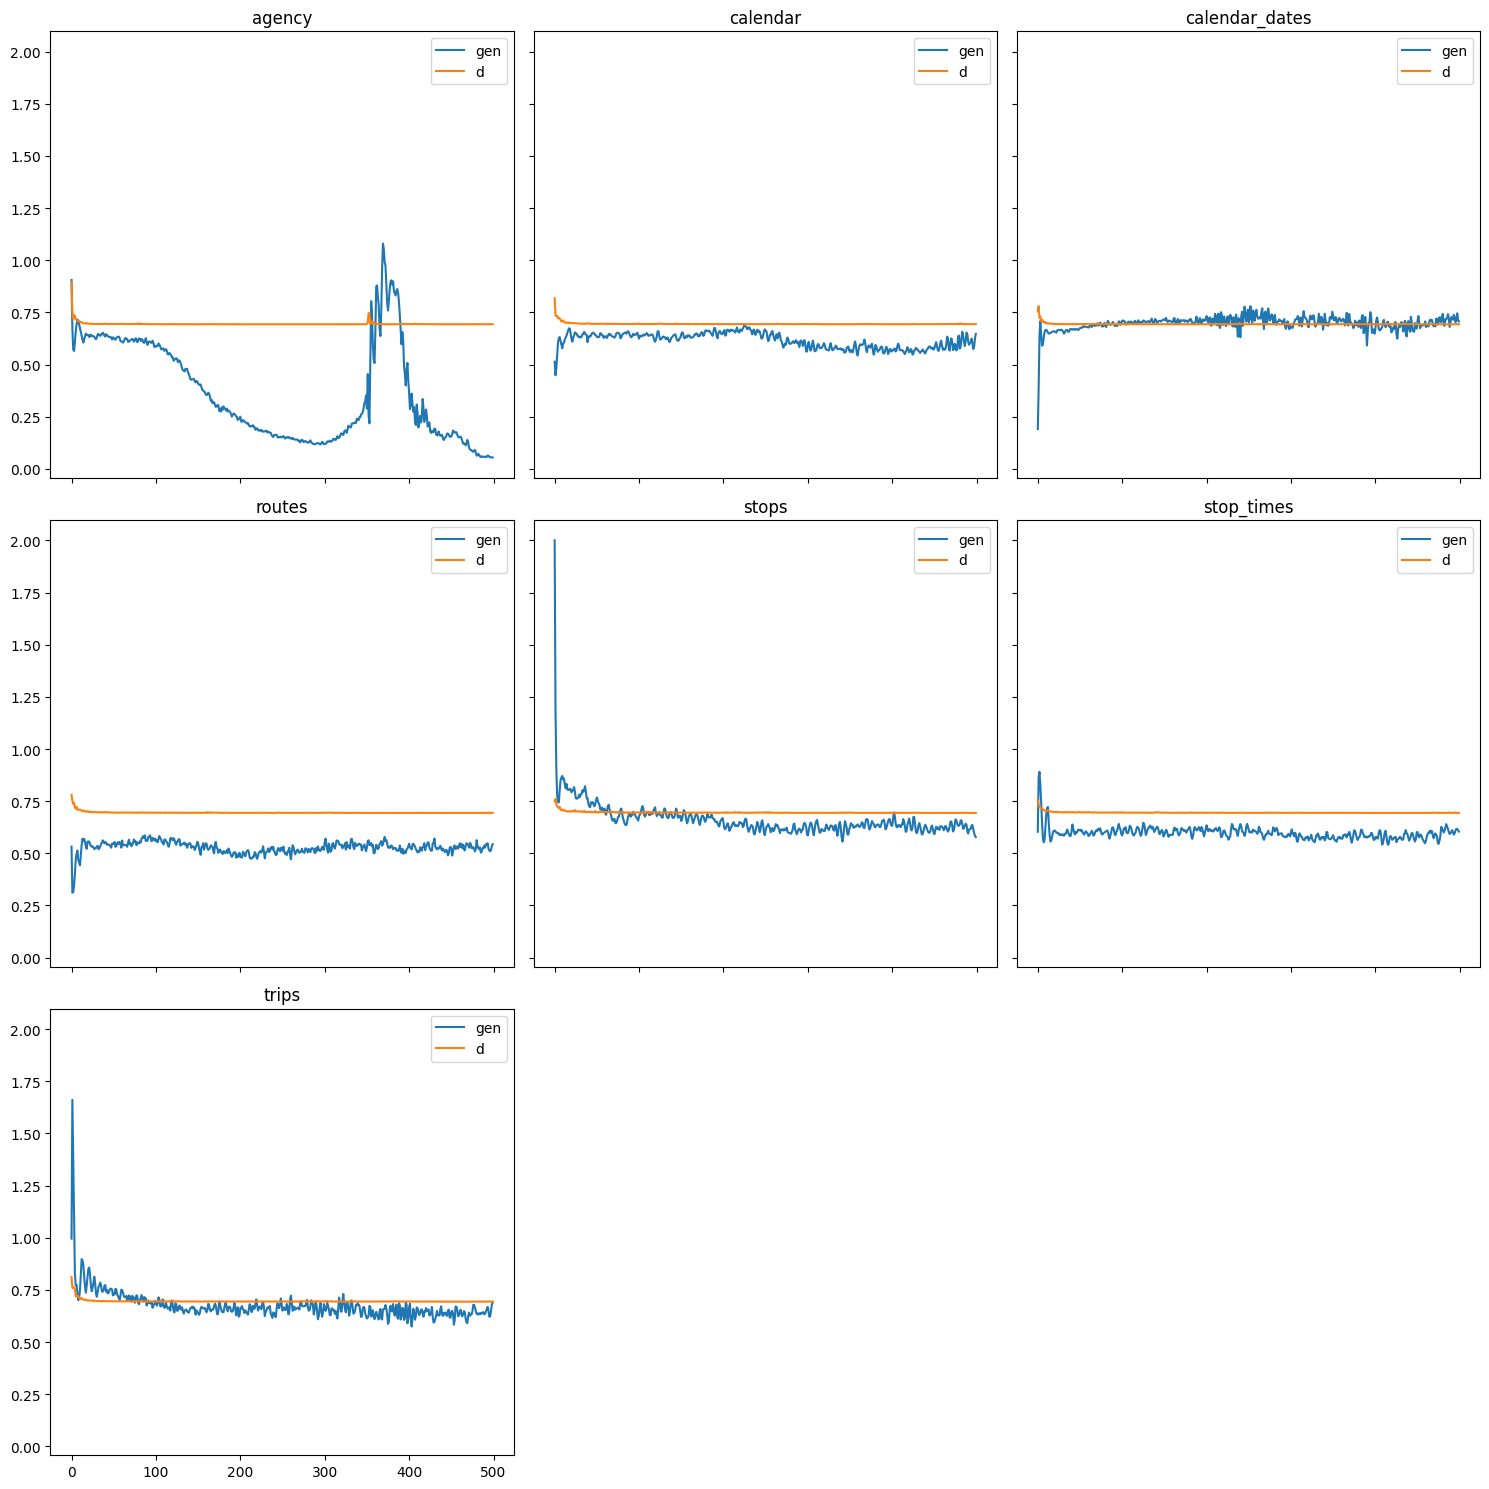

Total Time Used: 4m 35s


In [40]:
collection_training(processed_data_collection, training_parameter_dict)

# Synthetic Data Generation

In [41]:
# table_name:
# {'table':table, # df
#  'labels':labels, # df
#  'scaler':scaler, # a scaler object
#  'table_col_names':table_columns, # list of col names
#  'label_col_names':label_columns, # list of col names
#  'metadata':metadata[df_name]} # a metadata dict (see below)

# metadata
# {'primary_key':primary_key, # list, [column names, number_of_unique_ids]
#  'parent':parent, # dict, {parent_name:shared_id_column_name, ...}
#  'child':child} # str, child_name

In [42]:
# def generate_individual_synth_data(generator, labels, seed=123):
#     pass

In [43]:
def generate_synth_data_collection(processed_data_collection, generation_dict, latent_dim=100, seed=123):
    synthetic_data_collection = {}
    features_to_ignore_rounding = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']
    for df_name, content in processed_data_collection.items():
        generator = models.load_model('models/'+df_name+'_gan.h5')
        primary_key = content['metadata']['primary_key']
        child = content['metadata']['child']
        parent = content['metadata']['parent']
        fake_labels_df_dict = {}
        if primary_key != []:
            primary_key_col = primary_key[0]
            n_primary_keys = generation_dict[df_name]['nrows']
            fake_labels_df_dict[primary_key_col] = np.arange(n_primary_keys).tolist()
        if parent != {}:
            for parent_df_name, fr_key in parent.items():
                n_foreign_primary_keys = generation_dict[parent_df_name]['nrows']
                length = generation_dict[df_name]['nrows']
                fake_labels_df_dict[fr_key] = np.random.randint(0, n_foreign_primary_keys+1, length).tolist()
        fake_labels_df = pd.DataFrame(fake_labels_df_dict).reindex(columns=content['label_col_names'])
        scaled_fake_labels_df = pd.DataFrame(content['labels_scaler'].transform(fake_labels_df), columns=content['label_col_names'])
        noise = np.random.normal(0, 1, (generation_dict[df_name]['nrows'], latent_dim))
        raw_fake_table = generator.predict([noise, scaled_fake_labels_df])
        scaled_fake_table = content['table_scaler'].inverse_transform(raw_fake_table)
        fake_table_df = pd.DataFrame(scaled_fake_table, columns=content['table_col_names'])
        fake_data = pd.concat([fake_labels_df, fake_table_df], axis=1)
        
        columns_to_int = [col for col in fake_data.columns if col not in features_to_ignore_rounding]
        for col in columns_to_int:
            fake_data[col] = fake_data[col].round().astype(int)
                
        synthetic_data_collection[df_name] = fake_data
        
    return synthetic_data_collection

In [44]:
generation_dict = {k:{'nrows':len(v['table'])} for k,v in processed_data_collection.items()}

In [45]:
generation_dict

{'agency': {'nrows': 15},
 'calendar': {'nrows': 121},
 'calendar_dates': {'nrows': 674},
 'routes': {'nrows': 215},
 'stops': {'nrows': 6714},
 'stop_times': {'nrows': 966790},
 'trips': {'nrows': 32403}}

In [46]:
synthetic_data_collection = generate_synth_data_collection(processed_data_collection, generation_dict)

In [47]:
synthetic_data_collection

{'agency':     agency_id  agency_name  agency_url  agency_timezone  agency_lang  \
 0           0           11           1                1            1   
 1           1           11           1                1            1   
 2           2            8           1                1            1   
 3           3            9           1                1            1   
 4           4           10           1                1            1   
 5           5           11           1                1            1   
 6           6            8           1                1            1   
 7           7           10           1                1            1   
 8           8           11           1                1            1   
 9           9            8           1                1            1   
 10         10           11           1                1            1   
 11         11            8           1                1            1   
 12         12           11           1  

# Metrics

## Pre-metrics Data Processing

In [48]:
def convert_to_dataframe_collection(processed_data_collection):
    new_dict = {}
    features_to_ignore_rounding = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']
    for df_name, content in processed_data_collection.items():
        labels_scaler = content['labels_scaler']
        table_scaler = content['table_scaler']
        labels = content['labels']
        table = content['table']
        labels = pd.DataFrame(labels_scaler.inverse_transform(labels),columns = content['label_col_names'])
        table = pd.DataFrame(table_scaler.inverse_transform(table),columns = content['table_col_names'])
        new_df = pd.concat([labels, table], axis=1)
        columns_to_int = [col for col in new_df.columns if col not in features_to_ignore_rounding]
        for col in columns_to_int:
            new_df[col] = new_df[col].round().astype(int)
        new_dict[df_name] = new_df
    return new_dict

## Single-Table Metrics

### Basic Cosine Similarity Test

In [49]:
def cos_test(fake_collection, real_collection, repetitions=100, sample_size=1000, random_state=123):
    test_dict = {}
    for df_name in fake_collection.keys():
        # rng = np.random.default_rng()
        mean_cos = []
        for _ in range(repetitions):
            # fake_data_idx = rng.choice(fake_collection[df_name].shape[0], size=sample_size, replace=True)
            # real_data_idx = rng.choice(real_collection[df_name].shape[0], size=sample_size, replace=True)
            if fake_collection[df_name].shape[0] > sample_size and real_collection[df_name].shape[0] > sample_size:
                replace = False
            else:
                replace = True
            fake_sample = fake_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
            real_sample = real_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
            mean_cos.append(np.mean(metrics.pairwise.cosine_similarity(fake_sample, real_sample)))
            random_state += 1
        test_dict[df_name] = np.mean(mean_cos)
    return test_dict

In [50]:
cos_test(synthetic_data_collection, convert_to_dataframe_collection(processed_data_collection))

{'agency': 0.9999999999999978,
 'calendar': 0.9999996758714543,
 'calendar_dates': 0.9999993502959811,
 'routes': 0.922014653971782,
 'stops': 0.9921068093126679,
 'stop_times': 0.9652468822112908,
 'trips': 0.9760262942621775}

### PCA Cosine Similarity Test

In [51]:
def pca_cos_test(fake_collection, real_collection, repetitions=100, sample_size=1000, random_state=123):
    test_dict = {}
    for df_name in fake_collection.keys():
        if fake_collection[df_name].shape[0] > 1 and real_collection[df_name].shape[0]:
            pca = PCA(n_components=2)
            fake_data = pd.DataFrame(pca.fit_transform(fake_collection[df_name]))
            pca = PCA(n_components=2)
            real_data = pd.DataFrame(pca.fit_transform(real_collection[df_name]))
        else:
            continue
        mean_cos = []
        for _ in range(repetitions):
            # fake_data_idx = rng.choice(fake_collection[df_name].shape[0], size=sample_size, replace=True)
            # real_data_idx = rng.choice(real_collection[df_name].shape[0], size=sample_size, replace=True)
            if fake_data.shape[0] > sample_size and real_data.shape[0] > sample_size:
                replace = False
            else:
                replace = True
            fake_sample = fake_data.sample(sample_size, replace=replace, random_state=random_state)
            real_sample = real_data.sample(sample_size, replace=replace, random_state=random_state)
            mean_cos.append(np.mean(metrics.pairwise.cosine_similarity(fake_sample, real_sample)))
            random_state += 1
        test_dict[df_name] = np.mean(mean_cos)
    return test_dict

In [52]:
pca_cos_test(synthetic_data_collection, convert_to_dataframe_collection(processed_data_collection))

{'agency': -0.0008929231901623226,
 'calendar': 0.005102280177807245,
 'calendar_dates': -0.00036768397548742635,
 'routes': -0.0022324573518007467,
 'stops': -0.0006184504399077129,
 'stop_times': -9.65752283878538e-05,
 'trips': -0.00034907155979731}

### KS (Kolmogorov-Smirnov) Test

In [53]:
def batch_ks_test(fake_collection, real_collection, repetitions=100, sample_size=1000, random_state=123):
    test_dict = {}
    for df_name in fake_collection.keys():
        mean_k_stats = []
        mean_p_value = []
        for _ in range(repetitions):
            # fake_data_idx = rng.choice(fake_collection[df_name].shape[0], size=sample_size, replace=True)
            # real_data_idx = rng.choice(real_collection[df_name].shape[0], size=sample_size, replace=True)
            if fake_collection[df_name].shape[0] > sample_size and real_collection[df_name].shape[0] > sample_size:
                replace = False
            else:
                replace = True
            fake_sample = fake_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
            real_sample = real_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
            col_mean_k_stats = []
            col_mean_p_value = []
            for col_idx in range(fake_collection[df_name].shape[1]):
                fake_col = fake_sample.iloc[:, col_idx]
                real_col = real_sample.iloc[:, col_idx]
                k_stats, p_value = kstest(fake_col, real_col)
                col_mean_k_stats.append(k_stats)
                col_mean_p_value.append(p_value)
            mean_k_stats.append(np.mean(col_mean_k_stats))
            mean_p_value.append(np.mean(col_mean_p_value))
            random_state += 1
        test_dict[df_name] = test_dict[df_name] = {'k_stats':np.mean(mean_k_stats), 'p_value':np.mean(mean_p_value)}
    return test_dict

In [54]:
batch_ks_test(synthetic_data_collection, convert_to_dataframe_collection(processed_data_collection))

C:\programs\conda\envs\tfgpu\lib\site-packages\scipy\stats\_stats_py.py:8385: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return ks_2samp(xvals, yvals, alternative=alternative, method=method)


{'agency': {'k_stats': 0.7555366666666665, 'p_value': 0.1666666666666667},
 'calendar': {'k_stats': 0.5243950000000001, 'p_value': 0.09999999999999998},
 'calendar_dates': {'k_stats': 0.33445666666666674,
  'p_value': 3.414947454153766e-05},
 'routes': {'k_stats': 0.50286, 'p_value': 0.13921421011059348},
 'stops': {'k_stats': 0.6428945454545455, 'p_value': 0.27134632879277104},
 'stop_times': {'k_stats': 0.40487599999999996, 'p_value': 0.2582043503264015},
 'trips': {'k_stats': 0.42377875000000004, 'p_value': 0.2254034434040997}}

### JSD (Jensen-Shannon Distance) Test

In [55]:
# def jsd_test(fake_collection, real_collection, repetitions=100, sample_size=1000, random_state=123):
#     test_dict = {}
#     for df_name in fake_collection.keys():
#         mean_jsd = []
#         for _ in range(repetitions):
#             # fake_data_idx = rng.choice(fake_collection[df_name].shape[0], size=sample_size, replace=True)
#             # real_data_idx = rng.choice(real_collection[df_name].shape[0], size=sample_size, replace=True)
#             if fake_collection[df_name].shape[0] > sample_size and real_collection[df_name].shape[0] > sample_size:
#                 replace = False
#             else:
#                 replace = True
#             fake_sample = fake_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
#             real_sample = real_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
#             col_jsd_means = []
#             for col_idx in range(fake_sample.shape[1]):
#                 fake_col = fake_sample.iloc[:, col_idx]
#                 real_col = real_sample.iloc[:, col_idx]
#                 jsd = jensenshannon(fake_col, real_col)
#                 col_jsd_means.append(jsd)
#             mean_jsd.append(np.mean(col_jsd_means))
#             random_state += 1
#         test_dict[df_name] = test_dict[df_name] = np.mean(mean_jsd)
#     return test_dict

In [56]:
# jsd_test(synthetic_data_collection, real_data_collection)

## Multi-Table Metrics

### Cardinality Test

In [57]:
# cardinality = {}

# for parent, children in join_metadata.items():
#     parent_df = real_data_collection[parent]
#     for child, join_columns in children.items():
#         child_df = real_data_collection[child]
#         parent_col, child_col = join_columns

#         # Perform the join operation
#         joined_df = parent_df.merge(child_df, left_on=parent_col, right_on=child_col)

#         # Group by the parent join column and count the number of rows in each group
#         grouped_counts = joined_df.groupby(parent_col).size()

#         # Store the cardinality in the dictionary
#         cardinality[f'{parent}_{child}'] = grouped_counts
# cardinality

In [58]:
def calculate_cardinality(dataframes, relations):
    cardinality = {}
    for parent, children in relations.items():
        parent_df = dataframes[parent]
        for child, join_columns in children.items():
            child_df = dataframes[child]
            parent_col, child_col = join_columns

            joined_df = parent_df.merge(child_df, left_on=parent_col, right_on=child_col)
            grouped_counts = joined_df.groupby(parent_col).size()

            cardinality[f'{parent}_{child}'] = grouped_counts
    return cardinality

In [59]:
def cardinality_similarity(real_data, synthetic_data, relations):
    real_cardinality = calculate_cardinality(real_data, relations)
    synthetic_cardinality = calculate_cardinality(synthetic_data, relations)

    similarities = {}

    for key in real_cardinality.keys():
        real_counts = real_cardinality[key]
        synthetic_counts = synthetic_cardinality[key]

        aligned_counts = pd.concat([real_counts, synthetic_counts], axis=1, join='outer').fillna(0)
        aligned_counts.columns = ['real', 'synthetic']

        count_difference = np.abs(aligned_counts['real'] - aligned_counts['synthetic'])
        count_difference = np.abs(aligned_counts['real'] - aligned_counts['synthetic'])
        aligned_counts['difference'] = np.where(count_difference < aligned_counts['real'],
                                        count_difference / aligned_counts['real'],
                                        aligned_counts['real'] / count_difference)

        # aligned_counts['difference'] = count_difference / aligned_counts['real'] if count_difference < aligned_counts['real'] else aligned_counts['real'] / count_difference

        avg_difference = aligned_counts['difference'].mean()

        similarity = avg_difference
        similarities[key] = similarity

    return similarities

In [62]:
join_metadata = {'agency': {'routes': ['agency_id', 'agency_id']},
 'calendar': {'calendar_dates': ['service_id', 'service_id'],
  'trips': ['service_id', 'service_id']},
 'calendar_dates': {'trips': ['service_id', 'service_id']},
 'routes': {'trips': ['route_id', 'route_id']},
 'stops': {'stop_times': ['stop_id', 'stop_id']},
 'stop_times': {'trips': ['trip_id', 'trip_id']}}

In [63]:
cardinality_similarity(synthetic_data_collection, convert_to_dataframe_collection(processed_data_collection), join_metadata)

{'agency_routes': 0.6297284959704016,
 'calendar_calendar_dates': 0.5788709899186321,
 'calendar_trips': 0.799223004106894,
 'calendar_dates_trips': 0.8569999989440487,
 'routes_trips': 0.5354907423538101,
 'stops_stop_times': 0.5669100072786613,
 'stop_times_trips': 0.39888658190447374}